# Consumer Behavior Analytics - Data Analysis

**Libraries and imports**

In [1]:
# Basic libraries
import pandas as pd
import numpy as np

# Utils
# import lux
# import itertools
import datetime

# DataViz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Data libraries
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Notebook setup
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

## Schedule

### Exploratory Data Analysis
- Feature Engineering: discretizing and combining some variables.
- Univariate analysis
- Bivariate analysis

Let's keep an easy access to the data dictonary:

<img src="../images/data_dict.jpg" width="600" height="300">


### 0. Loading dataset

In [2]:
ccustomers = pd.read_csv('../data/customers_cleaned.csv') # ccustomers: cleaned customers 
ccustomers.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


In [3]:
ccustomers.shape

(2233, 27)

Since we will be using `Dt_Customer` for Feature Engineering, let's check the type of the date with `dtypes`.

In [4]:
ccustomers['Dt_Customer'].dtypes

dtype('O')

As an `object` (pandas way to say `str`) we won't be able to perform date operations. We need to transform it into a `datetime` object.

In [5]:
# Transforming Dt_Customer variable into a python datetime object
ccustomers['Dt_Customer'] = pd.to_datetime(ccustomers['Dt_Customer'])

We are all set. Let's mix some data.

## 1. Feature Engineering

Looking back at the Data Dictionary we can list some operations that might result interesting:

- Transform `Year_Birth` in `Age`.

### 1.1 Creating `Age` variable

In [6]:
ccustomers.shape

(2233, 27)

If we knew that the dataset was sampled in 2014 (the most recent date a customer become a client in our dataset, considering information from `Dt_Customer` variable) we could simply calculate:

\begin{align}
   2014 - \verb|Birth_Year|
\end{align}

But as for the information we have right now, we do not know when the dataset was sampled. Therefore we can't simply calcuate the difference between the dates.

**We need to determine when the dataset was sampled**, then.

The dataset, as instructed, is a _random sample_ of _hundreds of thousands_ of clients in the database, and our sample size, after cleaning, consists of 2,233 customers (which is an enourmous sample size if we want statisticly significant results).


<div class="alert alert-block alert-warning">
<b>Disclaimer:</b> This is a great example of how basic things, that could've been solved with a phone call to the owner of the dataset, can get unnecessarily tricky and can get in the way of the <i>real</i> analysis, specially if we are considering a <b>deadline</b>. For this reason, I'll move forward with some assumptions but I've decided to supress all the mathematical bureocracy of testing.
</div>

Since our sample is big enough, and we are assuming that it is random, we expect to see that the sample distribution of customers entrance in the company at a time $t$ (month, week, day, etc.) follows the population distribution. 

For exemple, if the company has a constant growth rate of clients aquisition, then the clients entrance to the company has a Uniform distribution. In other words, if on avergage $x$ people becomes a customer in $t$ time, then we should expect that the last period $t$ is the one when the dataset was sampled. 

In order to get the sample distribution of clients entrance (without abandoning scientific rigour) we need to investigate the time span of our data.

**Getting data time span**

In [7]:
min_date, max_date = ccustomers['Dt_Customer'].min().strftime('%d-%m-%Y'), \
                            ccustomers['Dt_Customer'].dt.date.max().strftime('%d-%m-%Y')

print('First date in our sample dataset is: ', min_date)
print('Last  date in our sample dataset is: ', max_date)

# Calculating timespan from max_date and min_date
span_df_months = (pd.to_datetime(max_date) - pd.to_datetime(min_date)) / np.timedelta64(1, 'M')
span_df_weeks = (pd.to_datetime(max_date) - pd.to_datetime(min_date)) / np.timedelta64(1, 'W')

print(f'\nOur data spans throughout {np.ceil(span_df_months)} months (equivalent to {np.ceil(span_df_weeks)} weeks).')

First date in our sample dataset is:  30-07-2012
Last  date in our sample dataset is:  29-06-2014

Our data spans throughout 23.0 months (equivalent to 100.0 weeks).


In [8]:
# ccustomers['Marital_Status'].value_counts().plot(kind = 'bar')

In [9]:
# Create dataset with features of interest
age_analysis = ccustomers[['Year_Birth', 'Dt_Customer', 'Recency']]

# Parse dates to Year-Month
age_analysis['year_month'] = ccustomers['Dt_Customer'].dt.strftime('%Y-%m')
age_analysis['year_week'] = ccustomers['Dt_Customer'].dt.strftime('%Y-%V') # Caution working with weekly aggregations!

Weekly aggregations tend to get wild for weeks between years. Let's check:

In [10]:
# Looping to get wrong weekly aggregations indexes 
is_weeklyagg_broken = []
for year in [2012, 2013, 2014]:
    is_broken = age_analysis[(age_analysis['year_month'] == f'{year}-12') & \
                             (age_analysis['year_week'] == f'{year}-01')] # If month = 12, then week cannot = 01
    is_weeklyagg_broken.append(is_broken.index.values)
    
# Seing indexes of broken weekly agg data 
is_weeklyagg_broken = np.hstack(is_weeklyagg_broken).squeeze()
is_weeklyagg_broken

array([1691,   36,  477,  747,  924, 1199, 1373])

In [18]:
# Reviewing entries with broken weekly agg
# age_analysis.loc[is_weeklyagg_broken] # Uncomment for dataset view

In [19]:
# Changing values to its correct counterparts
age_analysis['year_week'].iloc[is_weeklyagg_broken] = \
        age_analysis['year_week'].iloc[is_weeklyagg_broken].map({'2012-01': '2012-52', '2013-01': '2013-52'})

# Reviwing after change
# age_analysis.loc[is_weeklyagg_broken] # Uncomment for dataset view

Now that all date entries are correct, let's group them by `year_month` and `year_week`. These grouping will be necessary for checking clients' entrance distribution.

In [20]:
# Group data by Year-Month and by Year-Week
age_analysis_grouped_month_year = age_analysis.groupby(by = 'year_month').count()
age_analysis_grouped_week_year = age_analysis.groupby(by = 'year_week').count()

**Let's plot both `year_month` and `year_week` distributions:**

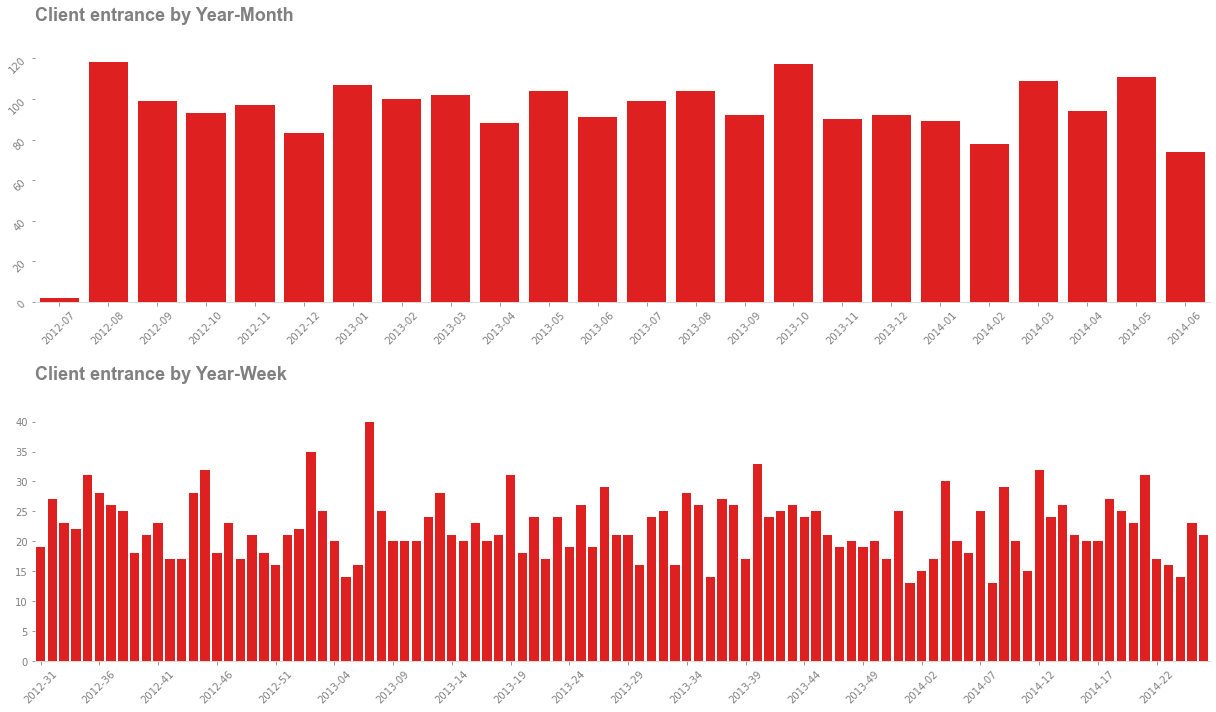

In [21]:
# Setting up plots
fig, ax = plt.subplots(2, 1, figsize = (17, 10))
sns.despine(top = True, left = True)

# Plot Year-Month Distribution
sns.barplot(x = age_analysis_grouped_month_year.index, 
            y = age_analysis_grouped_month_year['Year_Birth'], 
            ax = ax[0], 
            color = 'red')
ax[0].set(ylabel = None, xlabel = None)
ax[0].set_title('Client entrance by Year-Month', loc = 'left', size = 18, 
                pad = 30, fontweight = 'bold', fontname = 'Arial', color = 'gray')
ax[0].spines['bottom'].set_color('lightgray')
ax[0].xaxis.label.set_color('gray')
ax[0].tick_params(axis='both', colors='gray', rotation = 45)

# Plot Year-Year_week Distribution
sns.barplot(x = age_analysis_grouped_week_year.index, 
            y = age_analysis_grouped_week_year['Year_Birth'], 
            ax = ax[1],
            color = 'red')
ax[1].set_title('Client entrance by Year-Week',  loc = 'left', size = 18, 
                pad = 30, fontweight = 'bold', fontname = 'Arial', color = 'gray')
ax[1].set(ylabel = None, xlabel = None)
ax[1].spines['bottom'].set_color('lightgray')
ax[1].xaxis.label.set_color('gray')
ax[1].tick_params(axis='both', colors='gray')
plt.xticks(np.arange(0, len(age_analysis_grouped_week_year.index), step = 5), 
           rotation = 45)

plt.tight_layout(h_pad = 2);

As imagined, the aggregated data follows an Uniform distribution. If the company hasn't compromised itself in a _really bad way_ to the eyes of the public, and knowing it hasn't closed its doors (otherwise we probably wouldn't be working on this analysis), by the following months, we should expect that the numbers of customers joining the company as a client to be arround average of client entrances in the previous months. 

Straghtfowardly, it is highly unlikelly that no new person became a company's client after june 2014.

How's so?

If the sample is randon and the company is not seriously comprimised, and having a sample with 2,233 individuals, the probability of **not selecting a single one** of them who would've entered the data after june 2014 when sampling is really, really low.

In fact, we can say with $99 \%$ confidence (and margin of error of $\approx 2.7 \%$) that this sample would represent the actual population parameters, considering a population of $999,999$ individuals (the maximum in _hundreds of thousands_ as described in the guidelines of this project). As a reference, we can check the image below, from [Suvey Monkey's Sample Size Calculator](https://www.surveymonkey.com/mp/sample-size-calculator/).

<img src="../images/survey_monkey.jpg" width="800" height="400">

### **But...**

Before moving forward to set 2014 as the date the dataset was sampled, and then compute the age of the customers, there's still one piece of this puzzle which is outstanding and could be used for an integrity checkup.

The variable `Recency`, as described in our data dictionary, is the amount of days since a customer's last purchase. In theory, with our previous assumptions made, we should not have a client that entered in June 2014, having a purchased something several days before our dataset being sampled.

Let's check:

In [26]:
ccustomers[ccustomers['Recency'] == ccustomers['Recency'].max()].sort_values('Dt_Customer', ascending = False).head(1)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
1797,2831,1976,Graduation,Together,78416.0,0,1,2014-06-27,99,453,38,279,188,38,183,2,7,7,10,3,0,0,0,0,0,0,0


The customer with `ID` #2831 joined the the company as a client in June 2014 and his/hers last purchase was 99 days before the sampling!


<div class="alert alert-block alert-danger">
This is a huge compromise for the statistical analysis we just performed. Mainly, because we've statistcly proved that, everything kept constant, customers kept joining the company and none of them being select just means that our sample dataset <b>was not random <i>at all</i></b>.
</div>

Maybe, for some unkown reason, clients who've joined the company after June 2014 would be more propense to buy the device. Unfortunatelly, we won't be able to study this fenomena and therefore our analysis, and, by the way, our modeling, is enclosed in the time span of our sampling.

The results of our future model just gained a prefix introduction:

>— **_For clients who've joined the company until June 2014_** our model's performance is xxx.

Obviously, at some extent the model might be able to classify pretty well the _persona_ of those customer's who might be interested in purchasing the device, even for those who joined after June 2014. But it may as well go really bad, for these customers, when the model is in production. We cannot say, because we do not have the data to analyze.

At this point of the analysis, I would suggest a meeting with Research and Experiment Design department so everyone can be on the same page regarding what is random sampling and what are the implications when these conditions are not met.

In [27]:
ccustomers['Dt_Customer'].max()

Timestamp('2014-06-29 00:00:00')

#### (Finally) Let's calculate `Age`

Since we could not determine the date the dataset was generated, let's arbitrarly choose 2014 as the age of the dataset. $June \: 29^{th}, \: 2014 \: + \: 99 \: days$ would be still year 2014 and this is the closest information we have about a possible date of the dataset date cut. 

In [28]:
# Creating Age variable
ccustomers['Age'] = 2014 - ccustomers['Year_Birth']

ccustomers.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33


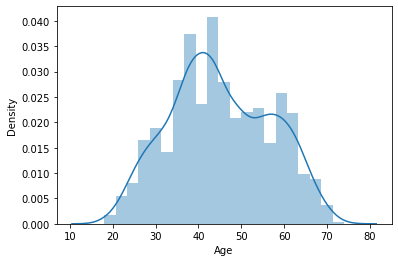

In [34]:
sns.distplot(ccustomers['Age']);

In [40]:
ccustomers['Kidhome'].value_counts()

0    1288
1     897
2      48
Name: Kidhome, dtype: int64

In [50]:
ccustomers['Income'] 

0       58138.0
1       46344.0
2       71613.0
3       26646.0
4       58293.0
         ...   
2228    61223.0
2229    64014.0
2230    56981.0
2231    69245.0
2232    52869.0
Name: Income, Length: 2233, dtype: float64

In [53]:
# Let's get income per capital per household per year

ccustomers['Income_PerCap'] = ccustomers['Income'] / (ccustomers['Marital_Status'].map({'Married': 2, 
                                                                                        'Together': 2,
                                                                                        'Single': 1,
                                                                                        'Divorced': 1,
                                                                                        'Widow': 1}) \
                                                    + ccustomers['Kidhome'] \
                                                    + ccustomers['Teenhome']) 

ccustomers.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Income_PerCap
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,57,58138.0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,60,15448.0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,49,35806.5
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,30,8882.0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,33,19431.0


In [54]:
# Proportion of spending on company's products to Income and Income_PerCap

------------------

In [ ]:
# ccustomers[ccustomers['Dt_Customer'] == ccustomers['Dt_Customer'].min()]

In [ ]:
# to_count = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
# for var in to_count:
#     print(ccustomers[var].value_counts(), '\n================================ \n')

In [ ]:
# purchase_flow = ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]
# purchase_flow['total'] = np.sum(ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']], axis = 1)
# # np.sum(np.array(ccustomers[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']]), axis = 1)
# ccustomers[purchase_flow['total'] == 5]

In [ ]:
# ccustomers['Recency'].hist();

In [ ]:
# ccustomers['Response'].value_counts()

In [ ]:
# ccustomers[ccustomers['Response'] == 1]['Recency'].hist()
# ccustomers[ccustomers['Response'] == 0]['Recency'].hist()